In [1]:
import sys
sys.path.append("../")
from utils.datasets import Datasets
from utils.save_results import save_info, plot_graph,  plot_histogram
from utils.networks import *
from utils.utils import dict_to_oneVSothers

from utils.adaptive_discriminantloss import AdaptiveDiscriminantLoss
from utils.classifier_discriminantloss import ClassifierDiscriminantLoss

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

f:\university\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1
SEED = 1
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

#Dataset config
DATASET = 'MNIST'
DATASET_DIR = './dataset'
BATCH_SIZE = 100
NUM_WORKERS = 2

#Optimizer config
WEIGHT_DECAY = 0.001
LEARNING_RATE = 0.01
GAMMA = 0.1
STEPS = 50

#Training config
EPOCH = 100

LAMBDA = 0.1
ALPHA = 0.9

In [3]:
torch.cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_trans = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
test_trans = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
instance_datasets = Datasets(
    DATASET,
    BATCH_SIZE,
    NUM_WORKERS,
    transform=train_trans,
    test_transform=test_trans,
    dataset_dir=DATASET_DIR,
)
data_sets = instance_datasets.create()

trainloader = data_sets[0]
testloader = data_sets[1]
classes = data_sets[2]
based_labels = data_sets[3]
input_channels = data_sets[4]
trainset = data_sets[5]
testset = data_sets[6]

Dataset : MNIST
set train data
set test data


In [5]:
model = Net(
    input_channels=input_channels,
    num_classes=len(classes),
).to(device)

optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=STEPS,
    gamma=GAMMA,
)

criterion = nn.CrossEntropyLoss()
discriminantloss = AdaptiveDiscriminantLoss(len(classes), ALPHA)

cfdl = ClassifierDiscriminantLoss(
    model,
    optimizer,
    criterion,
    discriminantloss,
    LAMBDA,
)

In [6]:
losses, cel_losses, discriminant_losses, accuracies = cfdl.fit(
    EPOCH,
    trainloader,
    testloader,
    scheduler=scheduler,
    device=device,
)

epoch:1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.13it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:08<00:00, 70.35it/s]


mean_loss=0.3831464757025242, mean_cel_loss=0.08309177356927346, mean_center_loss=3.0005469650030134, acc=0.9751833333333333
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.57it/s]


mean_loss=0.36373782113194464, mean_cel_loss=0.07630953419022263, mean_center_loss=2.874282789230347, acc=0.9756
epoch:2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:21<00:00, 27.88it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 65.95it/s]


mean_loss=0.2868236617992322, mean_cel_loss=0.04378864023912077, mean_center_loss=2.430350171327591, acc=0.9876333333333334
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.10it/s]

mean_loss=0.2765100885927677, mean_cel_loss=0.04305669459223282, mean_center_loss=2.3345338988304136, acc=0.9879


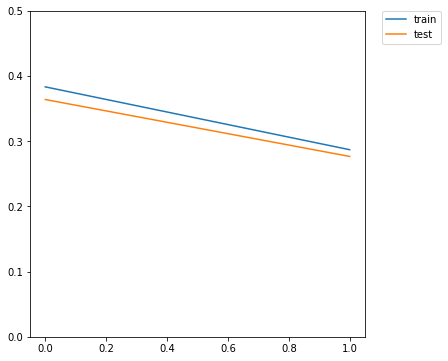

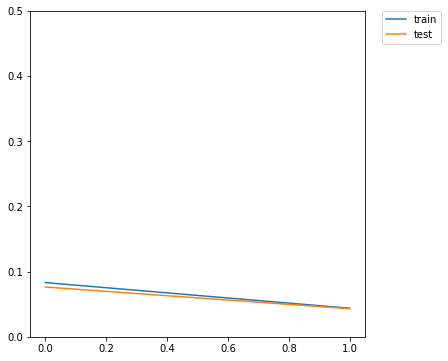

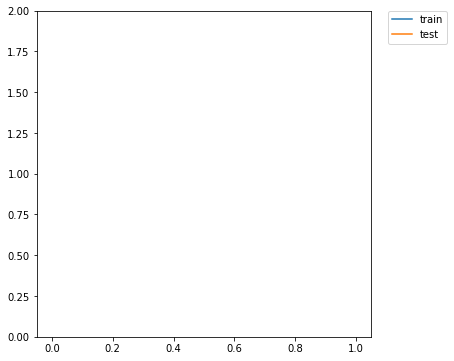

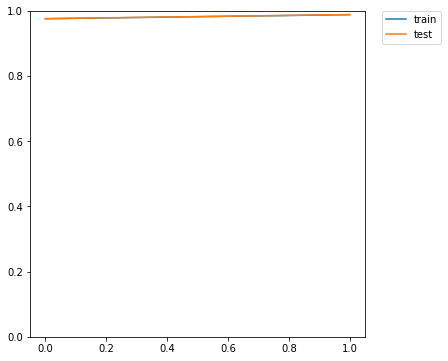

In [7]:
plot_graph(losses, 0.5, filename="loss")
plot_graph(cel_losses, 0.5, filename="cross entropy loss")
plot_graph(discriminant_losses, 2.0, filename="discriminant loss")
plot_graph(accuracies, 1, filename="accuracy")

In [8]:
info = {}
info["DATASET"] = DATASET
info["Learnign_rate"] = LEARNING_RATE
info["Weight_decay"] = WEIGHT_DECAY
info["EPOCH"] = EPOCH
info["STEPS"] = STEPS
info["GAMMA"] = GAMMA
info["Model"] = model
info["Criterion"] = criterion
info["Optimizer"] = optimizer
info["train_loss"] = losses["train"][-1]
info["test_loss"] = losses["test"][-1]
info["train_cel_loss"] = cel_losses["train"][-1]
info["test_cel_loss"] = cel_losses["test"][-1]
info["train_discriminant_loss"] = discriminant_losses["train"][-1]
info["test_discriminantr_loss"] = discriminant_losses["test"][-1]
info["train_acc"] = accuracies["train"][-1]
info["test_acc"] = accuracies["test"][-1]
info["LAMBDA"] = LAMBDA
info["ALPHA"] = ALPHA

In [9]:
save_info(info, DATASET+"_info")

In [10]:
torch.save(model.cpu().state_dict(), 'model_param.pth')
torch.save(model.cpu(), 'model.pth')

In [11]:
train_outputs = cfdl.getOutputs(trainloader, based_labels, device)
test_outputs = cfdl.getOutputs(testloader, based_labels, device)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.39it/s]


In [12]:
train_outputs = dict_to_oneVSothers(train_outputs)
test_outputs = dict_to_oneVSothers(test_outputs)

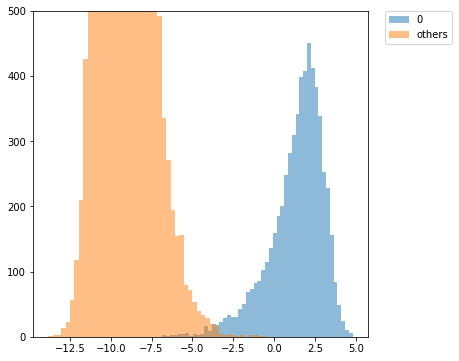

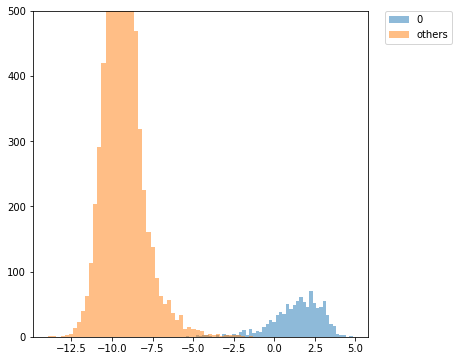

In [13]:
plot_histogram(train_outputs, filename="train_histogram")
plot_histogram(test_outputs, filename="test_histogram")